In [1]:
import numpy as np
import matplotlib.pyplot as plt

from RigidWallOverdampedLangevin3D import RigidWallOverdampedLangevin3D 

from mpl_toolkits import mplot3d
from scipy.signal import correlate

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 140

# Langevin 3D overdamped close rigid wall

In [2]:
langevin3D = RigidWallOverdampedLangevin3D(dt=1/6000, Nt=1000000, R=1.5e-6, rho=1050, x0=(0., 0., 1.5e-6))
langevin3D.trajectory()

## 1. Trajectory

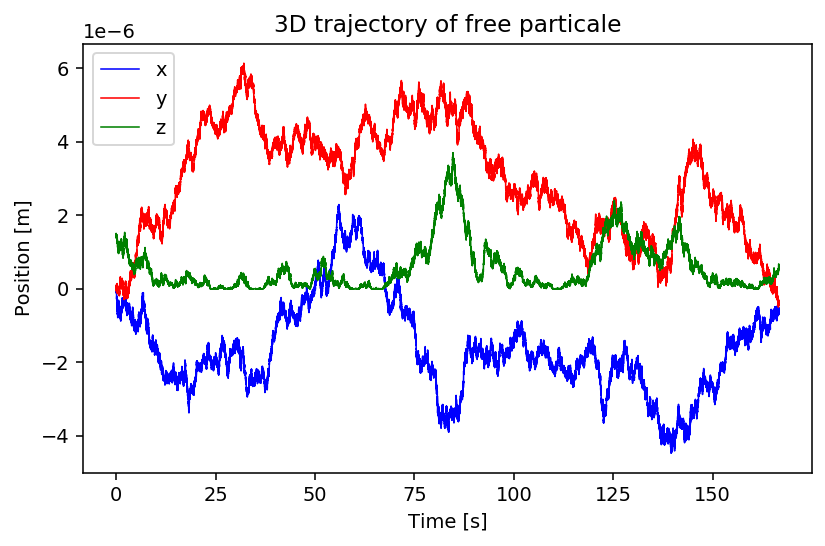

In [3]:
langevin3D.plotTrajectory()

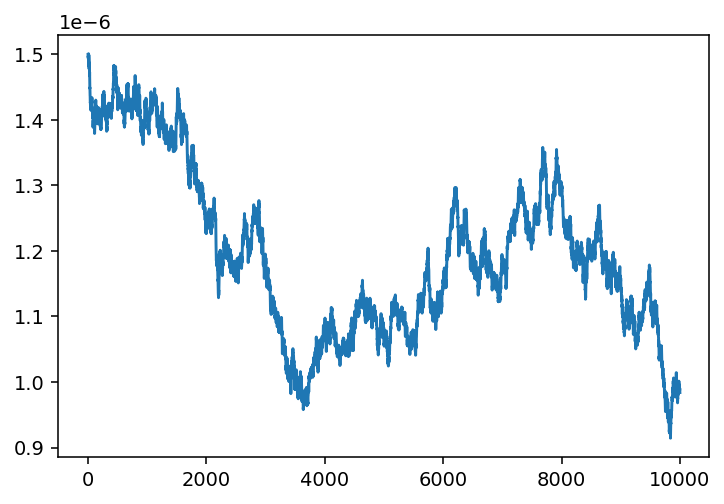

In [4]:
plt.plot(langevin3D.z[0:10000])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

## 2. Mean square displacement

In [5]:
MSDx = langevin3D.MSD1D("x", output=True)
MSDy = langevin3D.MSD1D("y", output=True)
MSDz = langevin3D.MSD1D("z", output=True)

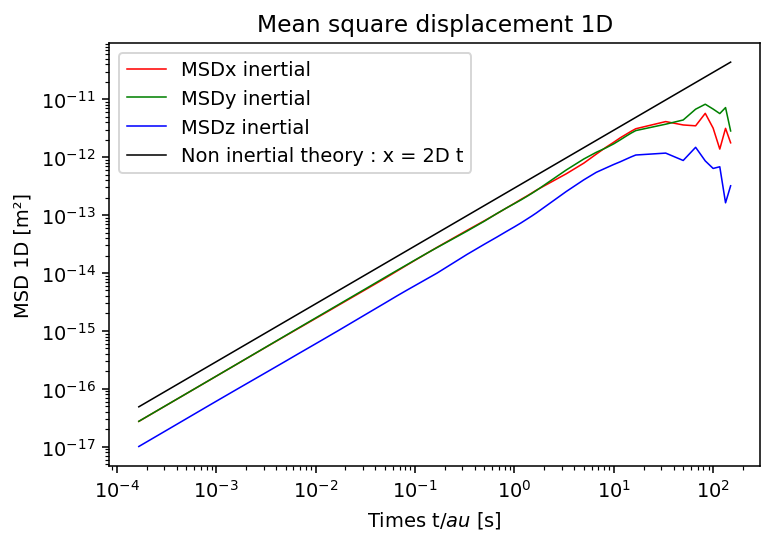

In [6]:
fig1 = plt.figure()
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD],
    MSDx,
    color="red",
    linewidth=0.8,
    label="MSDx inertial",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDy,
    color="green",
    linewidth=0.8,
    label="MSDy inertial",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDz,
    color="blue",
    linewidth=0.8,
    label="MSDz inertial",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    (2 * langevin3D.kb * langevin3D.T / langevin3D.gamma)
    * langevin3D.t[langevin3D.list_dt_MSD],
    color="black",
    linewidth=0.8,
    label="Non inertial theory : x = 2D t",
)
plt.xlabel("Times t/$ \tau $ [s]")
plt.ylabel("MSD 1D [m²]")
plt.title("Mean square displacement 1D")
plt.legend()
plt.show()

## 3. Probability density function of z

In [7]:
langevin3D.lB

5.970338334130222e-07

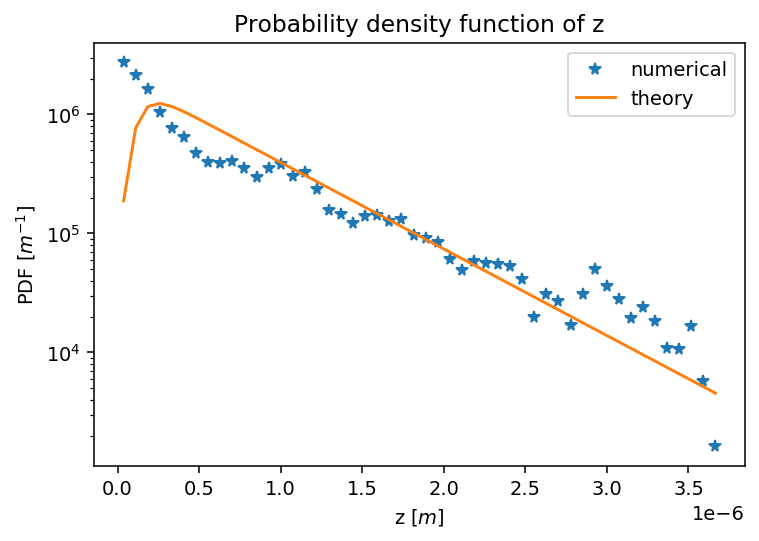

In [8]:
axis = "z"

hist, bin_edges = np.histogram(langevin3D.z, bins=50, density=True)
binsPosition = (bin_edges[:-1] + bin_edges[1:]) / 2
pdf = hist * 1/np.trapz(hist,binsPosition)

pdf_theo = np.exp( -(4) * np.exp(- binsPosition/langevin3D.lD) - binsPosition/langevin3D.lB)
pdf_theo = pdf_theo * 1/np.trapz(pdf_theo,binsPosition) # normalised

plt.semilogy(binsPosition,pdf, "*", label="numerical")
plt.plot(binsPosition, pdf_theo, "-", label="theory")

plt.title("Probability density function of " + axis)
plt.xlabel(axis + " $[m]$")
plt.ylabel("PDF $[m^{-1}]$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
#plt.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
plt.legend()
plt.show()

In [9]:
pdf_theo = np.exp( -(4) * np.exp(- binsPosition/langevin3D.lD) - binsPosition/langevin3D.lB)
1/np.trapz(pdf_theo,binsPosition)

2106592.0901846997

## 4. Mesure average of diffusion coeficient

In [10]:
# ----- On Z --------- !
# Diffusion coef
Dz = (langevin3D.kb*langevin3D.T) / (langevin3D._gamma_z(binsPosition))
# function to integrate
f_theo = Dz * pdf_theo
# Theoritical diffusion coef
mean_D_theo = np.trapz(f_theo,binsPosition)
print("<Dz>_theo/D_0 = {:.2f}".format(mean_D_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)))

# -------- On X ----------- !
Dx = (langevin3D.kb*langevin3D.T) / (langevin3D._gamma_xy(binsPosition))
fx_theo = Dx * pdf_theo
mean_Dx_theo = np.trapz(fx_theo,binsPosition)
print("<Dx>_theo/D_0 = {:.2f}".format(mean_Dx_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)))

<Dz>_theo/D_0 = 0.00
<Dx>_theo/D_0 = 0.00


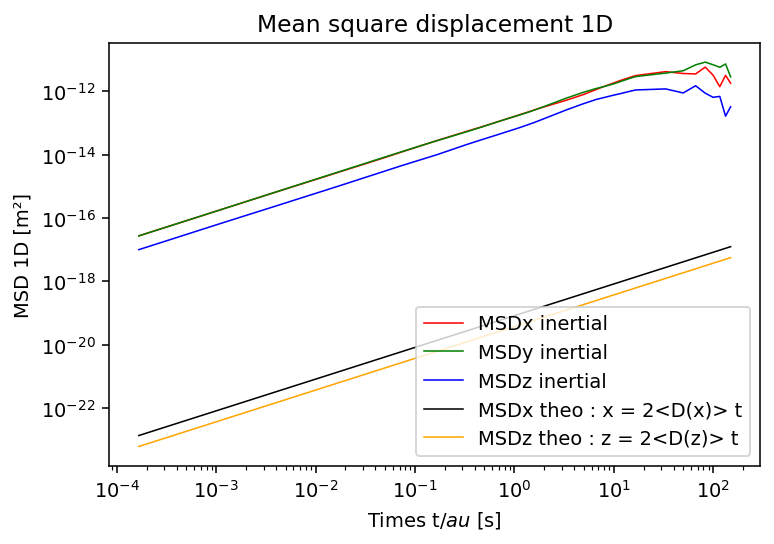

In [11]:
fig1 = plt.figure()
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD],
    MSDx,
    color="red",
    linewidth=0.8,
    label="MSDx inertial",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDy,
    color="green",
    linewidth=0.8,
    label="MSDy inertial",
)
plt.loglog(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    MSDz,
    color="blue",
    linewidth=0.8,
    label="MSDz inertial",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    2*mean_Dx_theo
    * langevin3D.t[langevin3D.list_dt_MSD],
    color="black",
    linewidth=0.8,
    label="MSDx theo : x = 2<D(x)> t",
)
plt.plot(
    langevin3D.t[langevin3D.list_dt_MSD] ,
    2*mean_D_theo
    * langevin3D.t[langevin3D.list_dt_MSD],
    color="orange",
    linewidth=0.8,
    label="MSDz theo : z = 2<D(z)> t",
)
plt.xlabel("Times t/$ \tau $ [s]")
plt.ylabel("MSD 1D [m²]")
plt.title("Mean square displacement 1D")
plt.legend()
plt.show()

In [12]:
mean_Dx_theo/(langevin3D.kb * langevin3D.T / langevin3D.gamma)

2.8454132020071505e-07

## 5. Les tests

In [13]:
zi_1 = langevin3D.z
gamma_z = langevin3D._gamma_z(zi_1)
gamma0 = langevin3D.gamma

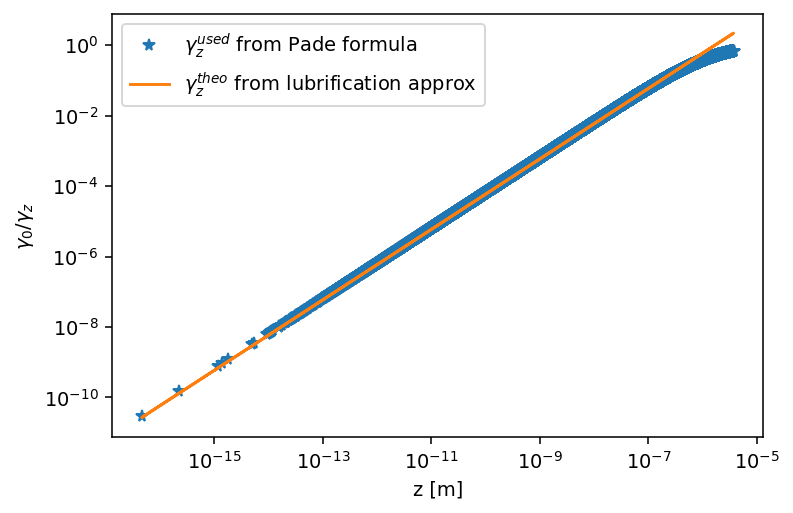

In [14]:
plt.loglog(zi_1, gamma0/gamma_z, "*", label="$\\gamma_z^{used}$ from Pade formula")
plt.plot(zi_1, 8/9 * zi_1/langevin3D.R, label="$\\gamma_z^{theo}$ from lubrification approx")
plt.xlabel("z [m]")
plt.ylabel("$\\gamma_0 / \\gamma_z$ ")
plt.legend(loc="upper left")

In [15]:
gamma_xy = langevin3D._gamma_xy(zi_1)

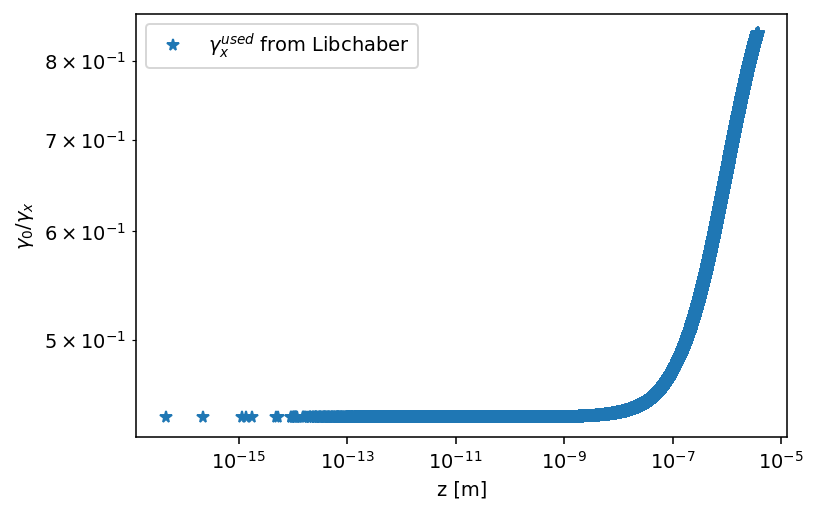

In [16]:
plt.loglog(zi_1, gamma0/gamma_xy, "*", label="$\\gamma_x^{used}$ from Libchaber")
plt.xlabel("z [m]")
plt.ylabel("$\\gamma_0/ \\gamma_x$")
plt.legend(loc="upper left")

In [17]:
weight = (langevin3D.delta_m) * langevin3D.g * np.ones(langevin3D.Nt)
elec = (
                (4 * langevin3D.kb * langevin3D.T)
                / (langevin3D.lD)
                * np.exp(-zi_1 / langevin3D.lD)
            )
correction = (
                langevin3D.kb
                * langevin3D.T
                * (42 * langevin3D.R * zi_1 ** 2 + 24 * langevin3D.R ** 2 * zi_1 + 4 * langevin3D.R ** 3)
                / ((6 * zi_1 ** 2 + 9 * langevin3D.R * zi_1 + 2 * langevin3D.R ** 2) ** 2)
            )

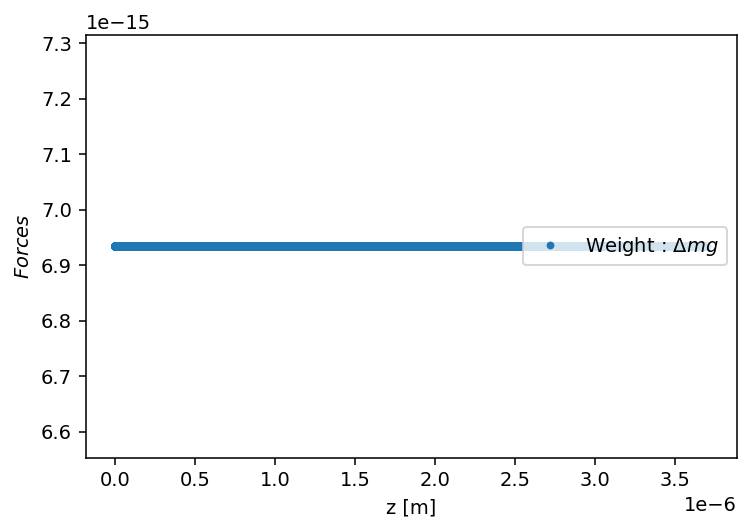

In [18]:
plt.plot(zi_1, weight, ".", label="Weight : $\\Delta m g $")
plt.xlabel("z [m]")
plt.ylabel("$Forces$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
#plt.axis([-1e-7, 1e-5, None, None])
plt.legend(loc="center right")

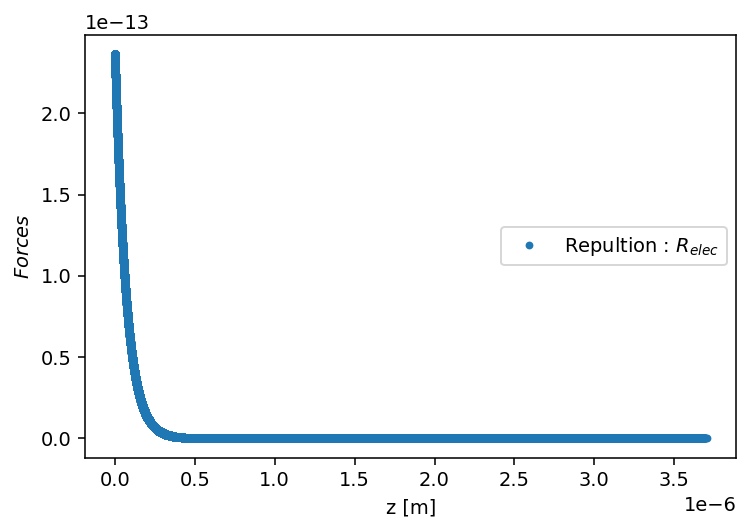

In [19]:
plt.plot(zi_1, elec, ".", label="Repultion : $R_{elec} $")
plt.xlabel("z [m]")
plt.ylabel("$Forces$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
#plt.axis([-1e-7, 1e-5, None, None])
plt.legend(loc="center right")

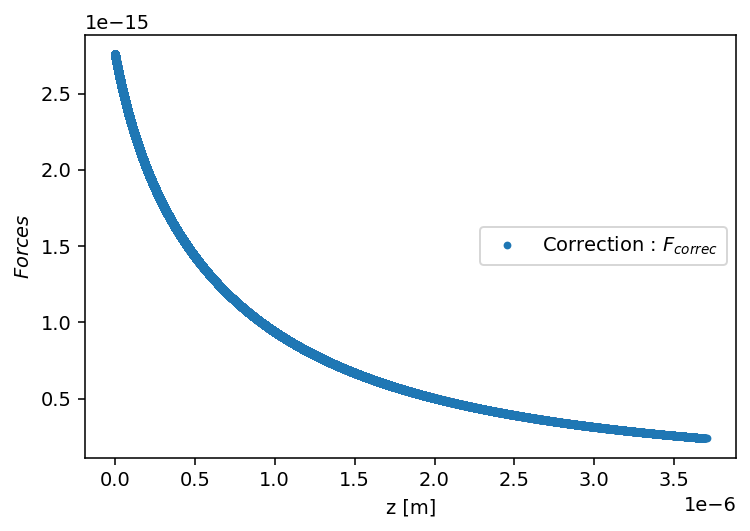

In [20]:
plt.plot(zi_1, correction, ".", label="Correction : $F_{correc}$ ")
plt.xlabel("z [m]")
plt.ylabel("$Forces$")
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
#plt.axis([-1e-7, 1e-5, None, None])
plt.legend(loc="center right")